# Plot classification performace (step 3)

In [125]:
import dask.dataframe as ddf
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

from Metrics import ir_metrics

BASE_PATH = "/Users/erotundo/PycharmProjects/DatasetAnnotatorProj/Analysis/Data/travel/"
PRED_PATH = BASE_PATH + "predictions_threads_acceptedOnly_ansCountGte2_binaryBestAnswer/"


# plotting settings
sns.set(style="white", palette="muted", color_codes=True)
PLOTS_PATH = 'output/travel/'
PLOTS_FORMATS = ['.pdf', '.png']

## Helper functions for computing metrics

In [177]:
def dcg_at_k(df, k, col):
    """
    Input: whole DF of all predictions
    Returns: array with a metric for each thread in DF
    """
    metrics = []
    for name, group in df.groupby(by='thread_id'):
        group = group.sort_values('y_true', ascending=False)
        metrics.append(ir_metrics.dcg_at_k(group[col], k, method=1))
    return metrics

def mrr(df, col):
    """
    Input: whole DF of all predictions
    Returns: float, a metric for the whole DF!
    """
    ranks = []
    for name, group in df.groupby(by='thread_id'):
        group = group.sort_values('y_true', ascending=False)
        ranks.append(group[col].values)
    return ir_metrics.mean_reciprocal_rank(ranks)

def precision_at_k(df, k, col):
    """
    Input: whole DF of all predictions
    Returns: array with a metric for each thread in DF
    """
    metrics = []
    for name, group in df.groupby(by='thread_id'):
        group = group.sort_values('y_true', ascending=False)
        try:
            metrics.append(ir_metrics.precision_at_k(group[col], k))
        except:
            pass
    return metrics

    
def add_random_predictions(df):
    """
    Input: whole DF of all predictions
    Returns: DF with +1 column for random predictions
    """
    rnd_preds_all = []
    for name, group in df.groupby(by='thread_id'):
        rnd_preds = np.random.randint(1, size=group.shape[0])
        position_for_1 = np.random.randint(group.shape[0], size=1)
        rnd_preds[position_for_1] = 1
        rnd_preds_all.extend(rnd_preds)
    df['rnd_pred'] = rnd_preds_all
    return df

## Compute metrics

In [183]:
mean_dcg_rnd = dict()
mean_mrr_rnd = dict()
mean_dcg_data = dict()
mean_mrr_data = dict()
mean_precision_data = dict()
ci_dcg_data = dict()
ci_mrr_data = dict()

files = ['AdaBoostClassifier',
         'KNeighborsClassifier',
         'LogisticRegression',
         'MLPClassifier',
         'RandomForestClassifier',
         'SVC']

files = ['RandomForestClassifier', 'LogisticRegression', 'SVC', 'KNeighborsClassifier']

for file_name in files:
    model_name = file_name
    print model_name,
    
    # init
    mean_dcg_rnd[model_name] = []
    mean_mrr_rnd[model_name] = []
    mean_dcg_data[model_name] = []
    mean_precision_data[model_name] = []
    mean_mrr_data[model_name] = []
    ci_dcg_data[model_name] = []
    ci_mrr_data[model_name] = []
    
    # read predictions
    df_model = pd.read_csv(PRED_PATH + file_name + "_predictions.csv")\
        .drop('Unnamed: 1', axis=1)\
        .drop('thread_id.1', axis=1)\
        .drop('pred_proba_class0', axis=1)\
        .drop('pred_proba_class1', axis=1)\
        .drop('post_id', axis=1)    
    
    # generate random predictions
    df_model = add_random_predictions(df_model)
    
    # compute metrics for different k
    for k in xrange(1, 11):
        print k,
        mean_dcg_data[model_name].append(np.mean(dcg_at_k(df_model, k, 'y_pred')))
        mean_mrr_data[model_name].append(mrr(df_model, 'y_pred'))
        mean_precision_data[model_name].append(np.mean(precision_at_k(df_model, k, 'y_pred')))

RandomForestClassifier 1 2 3 4 5 6 7 8 9 10 LogisticRegression 1 2 3 4 5 6 7 8 9 10 SVC 1 2 3 4 5 6 7 8 9 10 KNeighborsClassifier 1 2 3 4 5 6 7 8 9 10


## Time for plotting...

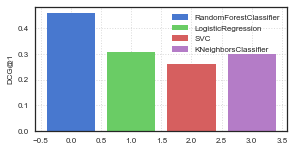

In [185]:
# plot DCG@1 bars

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

for idx, file_name in enumerate(files):
    ax1.bar(idx,  mean_dcg_data[file_name][0],  label=file_name)

plt.ylabel('DCG@1', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.7, linestyle='dotted')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'dcg1_bars' + plot_format)

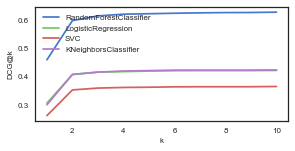

In [188]:
# plot NDCG curves

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

for model_name in files:
    ax1.plot(range(1, 11), 
             mean_dcg_data[model_name], 
             label=model_name)

plt.xlabel('k', fontsize=8)
plt.ylabel('DCG@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.0, linestyle='dotted')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'dcgK_lines' + plot_format)

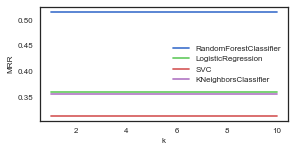

In [189]:
# plot MRR curves

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

for model_name in files:
    ax1.plot(range(1,11), 
             mean_mrr_data[model_name], 
             label=model_name)

plt.xlabel('k', fontsize=8)
plt.ylabel('MRR', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.0, linestyle='dotted')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'mrr_lines' + plot_format)

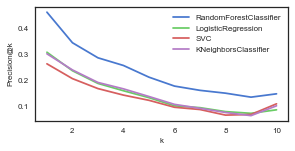

In [190]:
# plot P@1 curves

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

for model_name in files:
    ax1.plot(range(1,11), 
             mean_precision_data[model_name], 
             label=model_name)

plt.xlabel('k', fontsize=8)
plt.ylabel('Precision@k', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.grid(alpha=0.0, linestyle='dotted')
plt.legend(fontsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'precision_lines' + plot_format)

## Feature importances (RF)

In [63]:
from sklearn.externals import joblib
rf_path = '/Users/erotundo/PycharmProjects/DatasetAnnotatorProj/Analysis/Data/travel/' + \
'pickled_threads_acceptedOnly_ansCountGte2_binaryBestAnswer/' + \
'RandomForestClassifier_sklearn0.18.1.pkl'
clf = joblib.load(rf_path)
rf_est = clf.steps[0][1]

feat_names = pd.read_csv('/Users/erotundo/PycharmProjects/DatasetAnnotatorProj/Analysis/Data/travel/' + 
            'preprocessed_threads_acceptedOnly_ansCountGte2_binaryBestAnswer/' + 
            'development-0.csv')\
            .drop('best_answer', axis=1) \
            .drop('thread_id', axis=1) \
            .drop('post_id', axis=1) \
            .drop('Unnamed: 0', axis=1) \
            .drop('Unnamed: 0.1', axis=1) \
            .drop('index', axis=1) \
            .columns.values.tolist()
            
std = np.std([tree.feature_importances_ for tree in rf_est.estimators_],
             axis=0) / np.sqrt(len(rf_est.estimators_))            
f_importance = []

for (name, value), err in zip(zip(feat_names, rf_est.feature_importances_), std):
    f_importance.append((name, value, err))
f_importance = sorted(f_importance, key=lambda x: x[1], reverse=True)

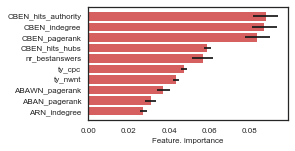

In [108]:
# top 10 feature importances

limit = 10

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

ax1.barh([record[0] for record in enumerate(f_importance[:limit])],
        [record[1] for record in f_importance[:limit]], 
        color="r", 
        align="center",
        xerr=[record[2] for record in f_importance[:limit]])
ax1.invert_yaxis()
plt.yticks(range(limit), 
           [record[1][0] for record in enumerate(f_importance[:limit])],
           rotation=0)

plt.xlabel('Feature. importance', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'feats_importance_top10' + plot_format)

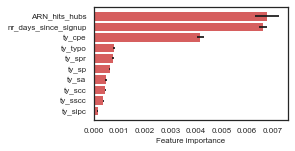

In [109]:
# least 10 feature importances

limit = 10

fig = plt.figure(figsize=(4, 2))
ax1 = fig.add_subplot(111)

ax1.barh( [record[0] for record in enumerate(f_importance[-limit:])],
        [record[1] for record in f_importance[-limit:]], 
        
        color="r", 
        align="center",
        xerr=[record[2] for record in f_importance[-limit:]])
ax1.invert_yaxis()
plt.yticks(range(limit), 
           [record[1][0] for record in enumerate(f_importance[-limit:])],
           rotation=0)

plt.xlabel('Feature importance', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout(pad=0.3)
for plot_format in PLOTS_FORMATS: 
    plt.savefig(PLOTS_PATH + 'feats_importance_least10' + plot_format)

## GridSearchCV analysis

In [ ]:
# TODO